<a href="https://colab.research.google.com/github/tomonari-masada/course2021-sml/blob/main/SML2020/RBF_kernel_example01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

出典:
https://github.com/ctgk/PRML

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Kernel(object):

    def _pairwise(self, x, y):
        return (
            np.tile(x, (len(y), 1, 1)).transpose(1, 0, 2),
            np.tile(y, (len(x), 1, 1))
        )



class RBF(Kernel):

    def __init__(self, params):
        assert params.ndim == 1
        self.params = params
        self.ndim = len(params) - 1

    def __call__(self, x, y, pairwise=True):
        assert x.shape[-1] == self.ndim
        assert y.shape[-1] == self.ndim
        if pairwise:
            x, y = self._pairwise(x, y)
        d = self.params[1:] * (x - y) ** 2
        return self.params[0] * np.exp(-0.5 * np.sum(d, axis=-1))

    def derivatives(self, x, y, pairwise=True):
        if pairwise:
            x, y = self._pairwise(x, y)
        d = self.params[1:] * (x - y) ** 2
        delta = np.exp(-0.5 * np.sum(d, axis=-1))
        deltas = -0.5 * (x - y) ** 2 * (delta * self.params[0])[:, :, None]
        return np.concatenate((np.expand_dims(delta, 0), deltas.T))

    def update_parameters(self, updates):
        self.params += updates

In [ ]:
class SupportVectorClassifier(object):

    def __init__(self, kernel, C=np.Inf):
        self.kernel = kernel
        self.C = C

    def fit(self, X:np.ndarray, t:np.ndarray, tol:float=1e-8):
        N = len(t)
        coef = np.zeros(N)
        grad = np.ones(N)
        Gram = self.kernel(X, X)

        while True:
            tg = t * grad
            mask_up = (t == 1) & (coef < self.C - tol)
            mask_up |= (t == -1) & (coef > tol)
            mask_down = (t == -1) & (coef < self.C - tol)
            mask_down |= (t == 1) & (coef > tol)
            i = np.where(mask_up)[0][np.argmax(tg[mask_up])]
            j = np.where(mask_down)[0][np.argmin(tg[mask_down])]
            if tg[i] < tg[j] + tol:
                self.b = 0.5 * (tg[i] + tg[j])
                break
            else:
                A = self.C - coef[i] if t[i] == 1 else coef[i]
                B = coef[j] if t[j] == 1 else self.C - coef[j]
                direction = (tg[i] - tg[j]) / (Gram[i, i] - 2 * Gram[i, j] + Gram[j, j])
                direction = min(A, B, direction)
                coef[i] += direction * t[i]
                coef[j] -= direction * t[j]
                grad -= direction * t * (Gram[i] - Gram[j])
        support_mask = coef > tol
        self.a = coef[support_mask]
        self.X = X[support_mask]
        self.t = t[support_mask]

    def lagrangian_function(self):
        return (
            np.sum(self.a)
            - self.a
            @ (self.t * self.t[:, None] * self.kernel(self.X, self.X))
            @ self.a)

    def predict(self, x):
        y = self.distance(x)
        label = np.sign(y)
        return label

    def distance(self, x):
        distance = np.sum(
            self.a * self.t
            * self.kernel(x, self.X),
            axis=-1) + self.b
        return distance

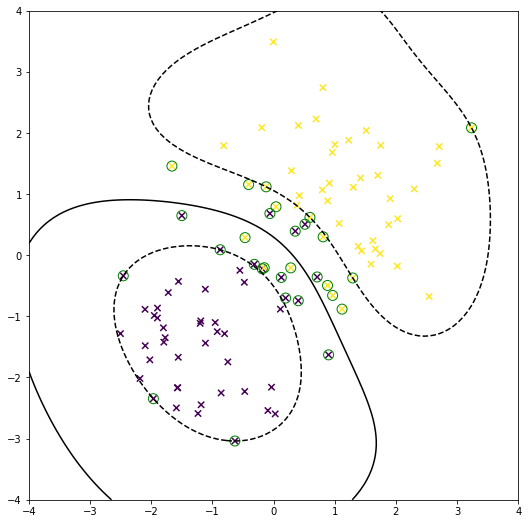

In [ ]:
def create_toy_data():
    x0 = np.random.normal(size=100).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=100).reshape(-1, 2) + 1.
    x = np.concatenate([x0, x1])
    y = np.concatenate([-np.ones(50), np.ones(50)]).astype(np.int)
    return x, y

x_train, y_train = create_toy_data()

model = SupportVectorClassifier(RBF(np.array([1., 0.5, 0.5])), C=1.)
model.fit(x_train, y_train)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.figure(figsize=(9,9))
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contour(x0, x1, model.distance(x).reshape(100, 100), np.arange(-1, 2), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")